In [1]:
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import torchvision
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
from torch.optim import lr_scheduler
import pandas as pd


In [2]:
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")
dataset_path = '~/datasets'


input_dim = 28 * 28
batch_size = 128
num_epochs = 60
learning_rate = 0.001
hidden_size = 512
latent_size = 2


In [3]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)


train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

In [4]:
class Encoder(torch.nn.Module):
    def __init__(self, D_in, H, latent_size):
        super(Encoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.enc_mu = torch.nn.Linear(H, latent_size)
        self.enc_log_sigma = torch.nn.Linear(H, latent_size)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        mu = self.enc_mu(x)
        log_sigma_squared_x = self.enc_log_sigma(x)
        sigma = torch.exp(log_sigma_squared_x)
        return mu, sigma, log_sigma_squared_x

In [5]:
class Decoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)
        

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x_hat = torch.sigmoid(self.linear2(x))
        return x_hat

In [6]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        
        z = mean + var*epsilon                          
        return z
        
                
    def forward(self, x):

        mu,sigma, log_sigma_squared_x = self.Encoder(x)
        #Reparametrization technique
        # q_z = torch.distributions.Normal(loc=mu, scale=sigma)
        # z = q_z.rsample()
        z = self.reparameterization(mu, torch.exp(0.5 * log_sigma_squared_x))
        x_hat = self.Decoder(z)

        return x_hat, mu, log_sigma_squared_x, z

In [7]:
encoder = Encoder(D_in=input_dim, H=hidden_size, latent_size=latent_size)
decoder = Decoder(D_in=latent_size, H = hidden_size, D_out = input_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [8]:


from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_sigma_squared_x):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_sigma_squared_x - mean.pow(2) - log_sigma_squared_x.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=learning_rate)

In [9]:
#model.load_state_dict(torch.load("./vaemodel/savemodel"))

In [10]:
print("Start training VAE...")
model.train()
all_losses=[]
random_z_values=[]

for epoch in range(num_epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(-1, input_dim).to(DEVICE)
    
        optimizer.zero_grad()
        x_hat, mean, log_sigma_squared_x, z = model(x)
        loss = loss_function(x, x_hat, mean,log_sigma_squared_x)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    all_losses.append(overall_loss / (batch_idx*batch_size))
pd.DataFrame(all_losses).to_csv("AllVAELosses.txt", sep="\t")
    
print("Training Complete")
torch.save(model.state_dict(),"./vaemodel/savemodelnew")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  187.8493170452933
	Epoch 2 complete! 	Average Loss:  164.48687065972223
	Epoch 3 complete! 	Average Loss:  159.41119136973325
	Epoch 4 complete! 	Average Loss:  156.80719155531662
	Epoch 5 complete! 	Average Loss:  155.23961999681262
	Epoch 6 complete! 	Average Loss:  153.87765559987125
	Epoch 7 complete! 	Average Loss:  153.00419983497034
	Epoch 8 complete! 	Average Loss:  151.99532251276523
	Epoch 9 complete! 	Average Loss:  151.2366983788645
	Epoch 10 complete! 	Average Loss:  150.66466033153046
	Epoch 11 complete! 	Average Loss:  150.0522448058821
	Epoch 12 complete! 	Average Loss:  149.65169914767273
	Epoch 13 complete! 	Average Loss:  149.29810853289743
	Epoch 14 complete! 	Average Loss:  148.81319773095285
	Epoch 15 complete! 	Average Loss:  148.50474072317792
	Epoch 16 complete! 	Average Loss:  148.1688752133622
	Epoch 17 complete! 	Average Loss:  147.8894848782792
	Epoch 18 complete! 	Average Loss:  147.68868470803287
	E

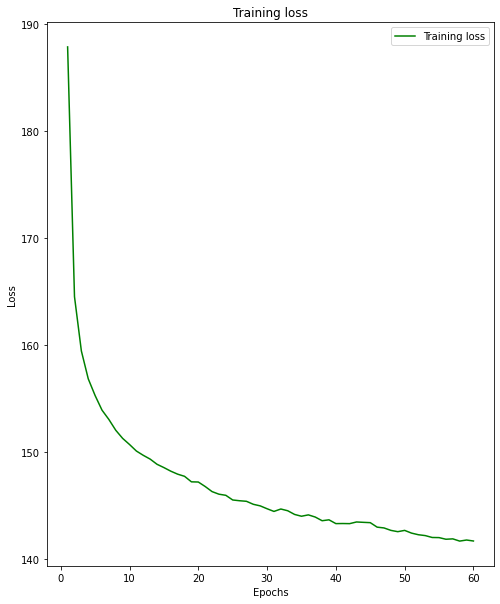

In [11]:
import matplotlib.pyplot as plt
loss_train = all_losses

epochs = range(1,61)
plt.rcParams["figure.figsize"] = [8, 10]
plt.plot(epochs, loss_train, 'g', label='Training loss')

plt.title('Training loss')

plt.xlabel('Epochs')

plt.ylabel('Loss')

plt.legend()

plt.show()

In [12]:
plt.rcParams["figure.figsize"] = [15, 30]
plt.rcParams["figure.autolayout"] = False
def show_images(images):
    images = torchvision.utils.make_grid(images, nrows=15)
    show_image(images)

def show_image(img):
    plt.imshow(img.permute(1, 2, 0), cmap="gray")
    plt.show()

In [13]:
model.eval()
vectors = []
z_vectors = pd.DataFrame(columns=["x","y","labels"])
random_z_values=[]
sampled_reconstructed_images_arr=torch.tensor([]).to(DEVICE)



with torch.no_grad():
  for i, (images, labels) in enumerate(test_loader):
    images = images.view(-1, input_dim).to(DEVICE)
    x_hat, mean, log_sigma_squared_x, z_vectors = model(images)

    random_z_samples = z_vectors
    reconstructed_image = x_hat.view(-1, 1, 28, 28)
    temp = list(zip(labels.tolist(), mean.tolist(), z_vectors.tolist(), reconstructed_image.tolist()))
    for x in temp:
      vectors.append(x)
    random_images = np.random.randint(len(z_vectors), size=5)
    sampled_reconstructed_images = reconstructed_image[random_images]
    if(len(sampled_reconstructed_images_arr)<225):
        sampled_reconstructed_images_arr = torch.cat((sampled_reconstructed_images_arr, sampled_reconstructed_images), 0)


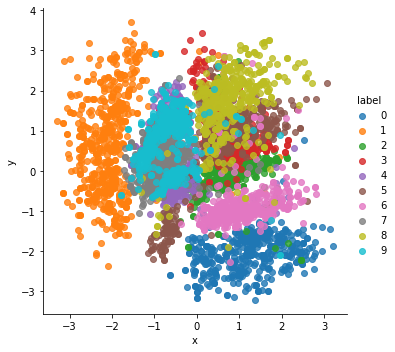

In [14]:
#QNo3(b). 

labels, means, z_vectors, reconstructed_image = list(zip(*vectors))
z_vectors = torch.tensor(z_vectors)
random_ids = np.random.randint(len(z_vectors), size=5000)
#New values
z_vectors = z_vectors[random_ids]
labels = np.array(labels)[random_ids]
C = z_vectors.tolist()
C = [x + [labels[i]] for i, x in enumerate(C)]


df = pd.DataFrame(C, columns=['x', 'y', 'label']) 
df.head()


import seaborn as sns
sns.lmplot( x="x", y="y", data=df, fit_reg=False, hue='label')

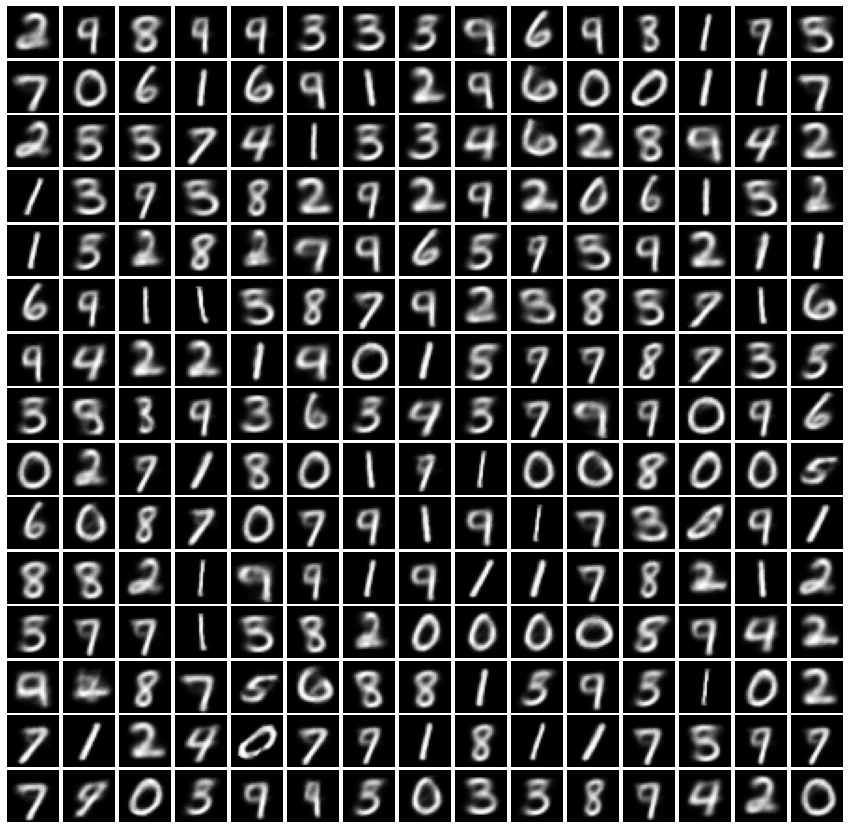

In [15]:
#QNo3(c)

def show_image_grid(images, batch_size=128):
    fig = plt.figure(figsize=(15, 15))
    gs = plt.GridSpec(15,15)
    gs.update(wspace=0.05, hspace=0.05)

    for i, image in enumerate(images):
        
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(image.reshape(28, 28)*0.5+0.5,cmap='gray')
    
    plt.show()


show_image_grid(sampled_reconstructed_images_arr.cpu())

In [16]:
labels, means, z_vectors, reconstructed_image = list(zip(*vectors))
reconstructed_image = torch.tensor(reconstructed_image)
random_ids = np.random.randint(len(reconstructed_image), size=25)
all_label_samples_arr=torch.tensor([])
for i in range(0,10):
    class_labels_idx =  (np.array(labels) == i).nonzero()
    if(len(class_labels_idx[0])>0):
        
        perm = torch.multinomial(torch.from_numpy(class_labels_idx[0]).float(),5)
        idx = perm[:5]
        samples = class_labels_idx[0][idx]
        reconstructed_image_new = reconstructed_image[samples]
        all_label_samples_arr = torch.cat((all_label_samples_arr, reconstructed_image_new), 0)

In [17]:
def show_image_grid_subsample(images, batch_size=128):
    fig = plt.figure(figsize=(8, 8))
    gs = plt.GridSpec(10,5)
    gs.update(wspace=0.05, hspace=0.05)

    for i, image in enumerate(images):
        
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(image.reshape(28, 28)*0.5+0.5,cmap='gray')
    
    plt.show()

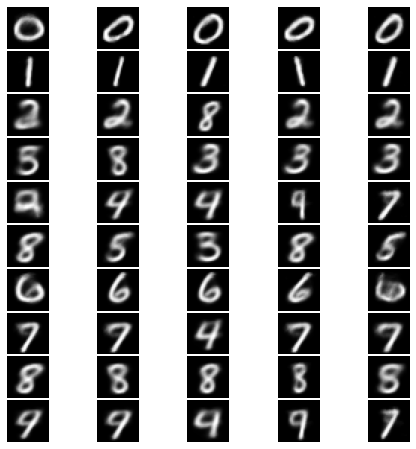

In [18]:
#Q.No.3d)

show_image_grid_subsample(all_label_samples_arr)